Tutorial 5: Masking and Positions
=================================

We have learnt everything we need to know about non-linear searches to model a strong lens and infer a good lens
model solution. Now, lets consider masking in more detail, something we have not given much consideration previously.
We'll also learn a neat trick to improve the speed and accuracy of a non-linear search.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

we'll use the same strong lensing data as tutorials 1 & 2, where:

 - The lens galaxy's total mass distribution is a `SphIsothermal`.
 - The source galaxy's `LightProfile` is a `SphExponential`.

In [2]:
dataset_name = "mass_sis__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

__Masking__

In this tutorial, our data only contained the light from the lensed source. We therefore want our mask to include all 
of the source's light. There are different shaped masks that we can use to achieve this, and we can compare them by
plotting masks on the imaging data.

Below, we use a 'circular_annular' mask, which unlike the 'circular' masks we have used previous includes an additional
input parameter 'inner_radius' that removes the central regions of the image. Below, we use too large of a value of
`inner_radius=1.4`, which cuts into the lensed source galaxy's light, clearly this isn't a good mask.

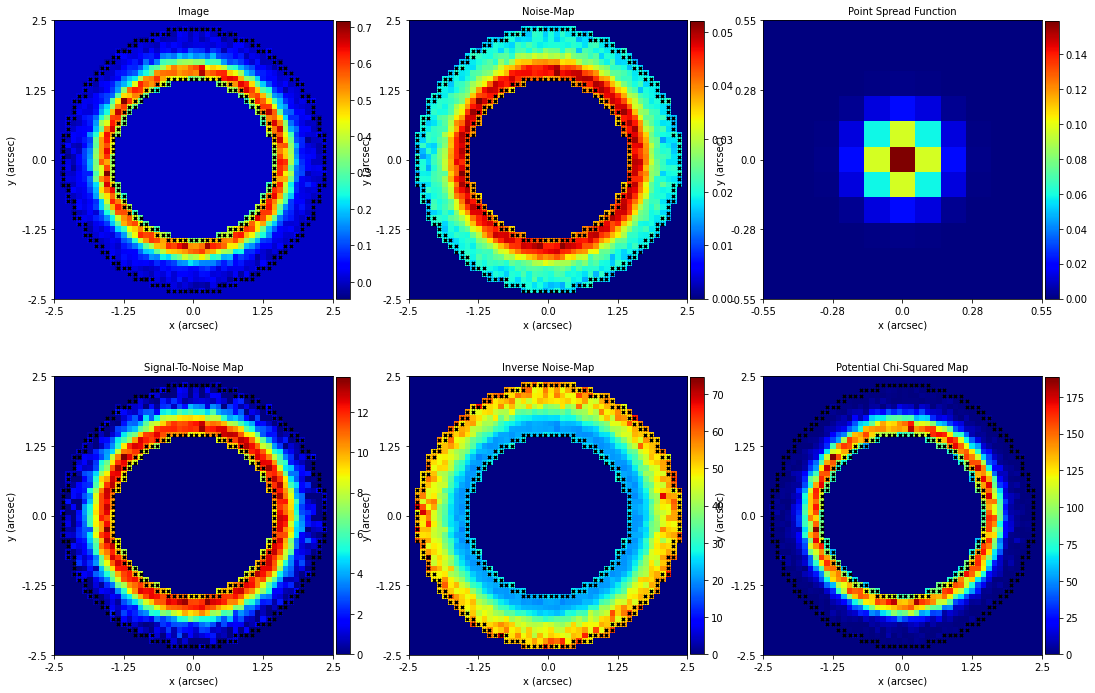

In [3]:
mask = al.Mask2D.circular_annular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    inner_radius=1.4,
    outer_radius=2.4,
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

We can decrease the `inner_radius` to correct for this.

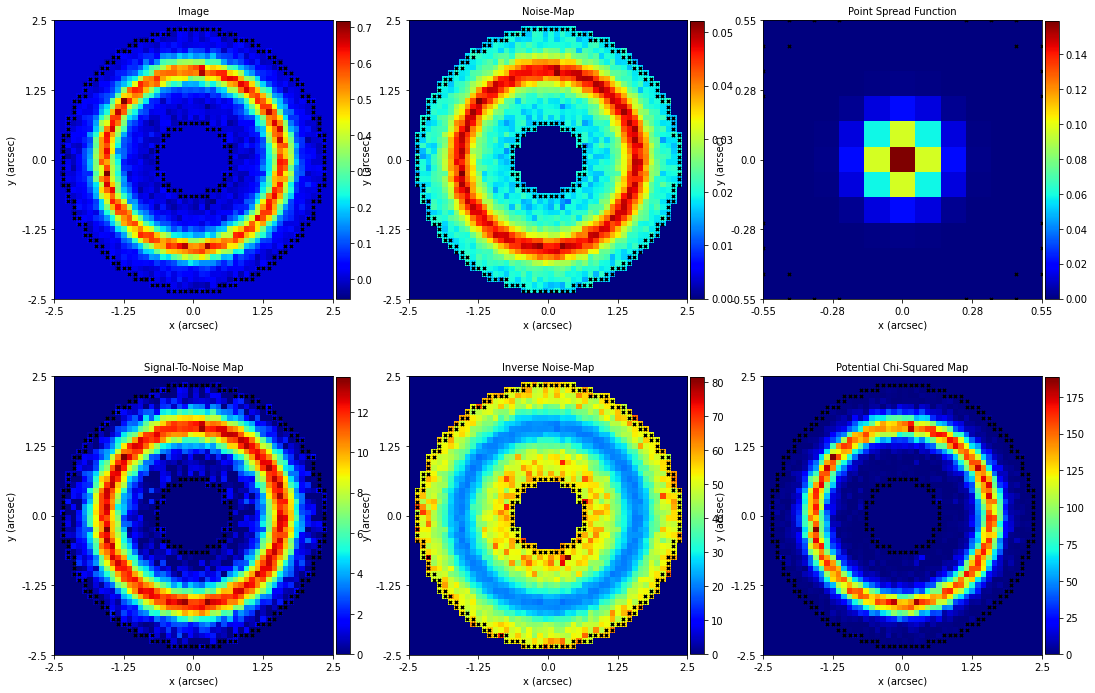

In [4]:
mask = al.Mask2D.circular_annular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    inner_radius=0.6,
    outer_radius=2.4,
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Model + Search + Analysis__

Lets fit the data using this mask, by creating the search as per usual. Note that the `imaging` data with this mask
applied is passed into the `AnalysisImaging` object, ensuring that this is the mask the model-fit uses. 

In [5]:
model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(al.Galaxy, redshift=0.5, mass=al.mp.SphIsothermal),
        source=af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.SphExponential),
    )
)

search = af.DynestyStatic(
    path_prefix=path.join("howtolens", "chapter_2"),
    name="tutorial_5_with_custom_mask",
    nlive=40,
    number_of_cores=1,
)

analysis = al.AnalysisImaging(dataset=imaging)

search.fit(model=model, analysis=analysis)

INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00,  6.43it/s, +40 | bound: 0 | nc: 1 | ncall: 42 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.049]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Discussion__

So, we can choose the mask we use in a model-fit. We know that we want the mask to not remove any of the lensed source 
galaxy's light, but is this the 'right' mask? What is the 'right' mask? Maybe we want a bigger mask? a smaller mask?

When it comes to choosing a mask, we are essentially balancing two things: computational run-time and accuracy. When we
use a bigger the mask the model-fit will take longer to perform. Why? Because a bigger mask includes more image-pixels 
in the analysis, and for every additional image-pixel we have to compute its deflection angles, trace it to the source
plane, fit its light, etc.
 
If run-time was not a consideration we would always choose a bigger mask, for two reasons:

 1) The lensed source galaxy may have very faint emission that when you choose the mask you simply do not notice. 
 Overly aggressive masking runs the risk of us inadvertantly masking out some of the source's light, which would 
 otherwise better constrain the lens model!
    
 2) When the data is fitted with a model image, the fit is performed only within the masked region. For certain lens
 models it is possible that it may produce extraneous source emission outside of the masked region that is not actually
 observed in the lens data itself. If this region had not been masked-out, the model would create residuals in these
 locations and reduce the value of likelihood appropriate, whereas if it is masked out this reduction in likelihood is 
 not fed through to the analysis. 

As you use **PyAutoLens** more you will get a feel for how fast a model-fit will run given the quality of data, lens 
model complexity, non-linear search settings, etc. As you develop this intuition, I recommend that you always aim to 
use as large of a mask as possible (which still achieving reasonable run-times) Aggressive masking will make 
**PyAutoLens** run very fast, but could lead you to infer an incorrect lens model! 

In the chapter 3, where we introduce 'non-linear search chaining' we will see how we use tighter masks in earlier 
searches to achieve faster run times.

If your data includes the light of the foreground lens galaxy you pretty much have no choice but to use a large 
circular mask, because it is important to capture the lens galaxy's extended emission. This will probably extend well 
beyond the light of the source. Nevertheless, the size of this circular mask will still play an important role in the
overall run time!

__Positions__

We can manually specify a set of image-plane (y,x) coordinates corresponding to the multiple images of a strong lens's 
source-galaxy. If we supply these positions, every time a lens model is fitted **PyAutoLens** will first check that 
these pixels trace within a specified arc-second threshold of one another in the source-plane (which is controlled 
by an input `position_threshold`). If they do not trace within this threshold of one anothr, the lens model is discarded
and Dynesty samples a new lens model.

This provides two benefits:

 1) The model-fit is faster as the non-linear search avoids searching regions of parameter space where the mass-model 
 is clearly not accurate (given that models which do not trace the source's brightest image-plane pixels close to 
 one another in the source plane simply cannot fit the data accurately).
    
 2) By removing these solutions, a global-maximum solution may be reached instead of a local-maxima. This is 
 because removing the incorrect mass models makes the non-linear parameter space less complex.

We can create the image-plane positions using the `Grid2DIrregular` object, which defines a grid of $(y,x)$ coordinates
which are on an irregular grid (in contrast to the `Grid2D` object which assumes the $(y,x)$ coordinates are on a 
regular uniform grid). T

In [6]:
positions = al.Grid2DIrregular(grid=[(1.6, 0.0), (0.0, 1.6), (-1.6, 0.0), (0.0, -1.6)])

To check the image-positions are accurate we can plot them using the `Visuals2D` object (they are the magenta dots on 
the image).

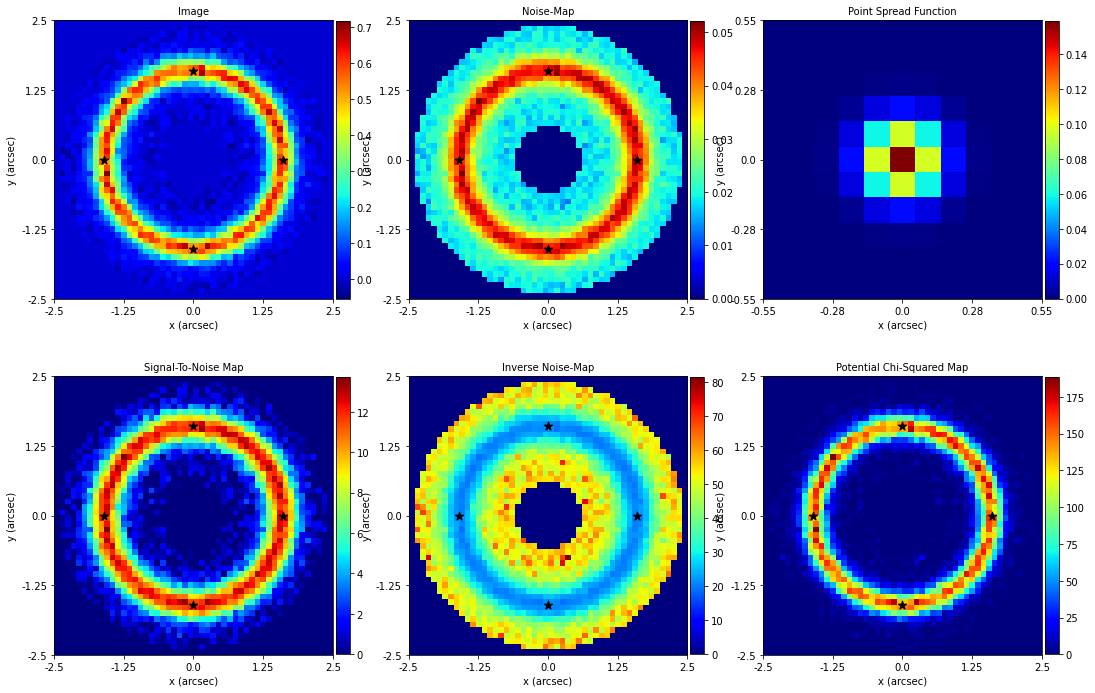

In [7]:
visuals_2d = aplt.Visuals2D(positions=positions)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging, visuals_2d=visuals_2d)
imaging_plotter.subplot_imaging()

For the positions to be used in a model-fit, we pass them to the `AnalysisImaging` class. We also pass a `SettingsLens` 
object which includes the `position_threshold` that the positions must trace within during model-fit for a lens model 
to be accepted and not resampled. 

We use a threshold of 1.0"; this is a very large value. When we have plotted source-planes throughout the tutorials, the
extent of the source-plane overall is typically less than 1.0"! If the multiple images of the source only trace within 
1.0" of one another, the lens model will not provide a good fit! 

We choose an excessively large threshold for two reasons:

 1) Even with such a large value, we still remove the *vast majority* of unphysical lens models which trace the
 pixels even further away in the source plane.
 
 2) If we set the threshold too low, there is a risk we may remove physically plausible solutions. An ultra 
 conservative value of 1.0" therefore a wise choice.

In [8]:
settings_lens = al.SettingsLens(positions_threshold=1.0)

analysis = al.AnalysisImaging(
    dataset=imaging, positions=positions, settings_lens=settings_lens
)

search = af.DynestyStatic(
    path_prefix=path.join("howtolens", "chapter_2"),
    name="tutorial_5_with_positions",
    nlive=40,
    number_of_cores=1,
)

print(
    "Dynesty has begun running - checkout the workspace/output/t7_with_positions"
    "  folder for live output of the results, images and lens model."
    "  This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!"
)

search.fit(model=model, analysis=analysis)

print("Dynesty has finished run - you may now continue the notebook.")

INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 200.23it/s, +40 | bound: 0 | nc: 1 | ncall: 42 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.049]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).


Dynesty has begun running - checkout the workspace/output/t7_with_positions  folder for live output of the results, images and lens model.  This Jupyter notebook cell with progress once Dynesty has completed - this could take some time!


INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


Dynesty has finished run - you may now continue the notebook.


__Wrap Up__

You may now wish to checkout the `autolens_workspace/notebooks/imaging/preprocess` package. This includes tools for 
creating custom masks and marking the positions on a strong lens (via a GUI) so you can use them in a model-fit.

There are two things you should bare in mind in terms of masking and positions:

 1) Customizing the mask and positions for the analysis of one strong lens gets the analysis running fast and can 
 provide accurate non-linear sampling. However, for a large sample of lenses, this high level of customization may take 
 a lot of time. 
    
 2) When using positions, we must be *extremely* careful. It is often unclear whether a lensed source consists of one 
 or more galaxies, and each galaxy may have multiple distinct sources of light. When you mark the positions, they may 
 not truly originate from the same location in the source-plane. This is why the conservative positions threshold of
 1.0" is wise, as it is sufficiently large that even if the detailed structure of the source means we mark the positions
 incorrectly it will not mean that we remove physically plausible mass models. 